In [1]:
import pandas as pd
import numpy as np
import imageio.v3 as iio
import os

import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import matplotlib.pyplot as plt

import time

## Load Data

In [2]:
img = iio.imread("COVID-19_Lung_CT_Scans/COVID-19/COVID-19_0001.png")
img.min(), img.max()

(0, 255)

In [3]:
# Creating the annotations_file
filenames = os.listdir('COVID-19_Lung_CT_Scans/COVID-19/')

arr = []
for file in filenames:
    if '.png' not in file: continue
    label = 0 if 'Non' in file else 1
    arr.append([file, label])

df = pd.DataFrame(arr)
print(df.shape)
df.to_csv('COVID-19_Lung_CT_Scans/annotations_file.csv', index=False, header=False)

(8439, 2)


In [4]:
class CovidCTDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.img_labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [5]:
data = CovidCTDataset(annotations_file='COVID-19_Lung_CT_Scans/annotations_file.csv', 
                      img_dir='COVID-19_Lung_CT_Scans/COVID-19/')

In [6]:
train_set, test_set = random_split(data, [0.8, 0.2])

In [7]:
trainloader = DataLoader(train_set, batch_size=4, shuffle=True)
testloader = DataLoader(test_set, batch_size=4, shuffle=False)

In [8]:
len(trainloader.dataset), len(testloader.dataset)

(6751, 1687)

In [9]:
classes = ('Non-COVID-19', 'COVID-19')

torch.Size([4, 1, 512, 512])


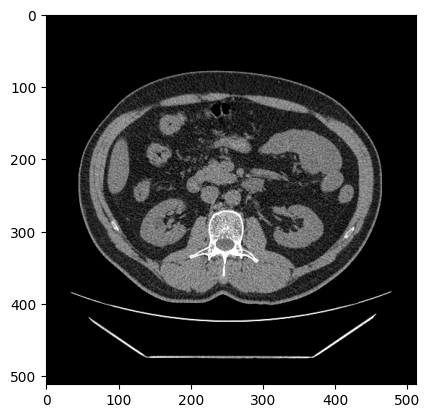

Label: COVID-19


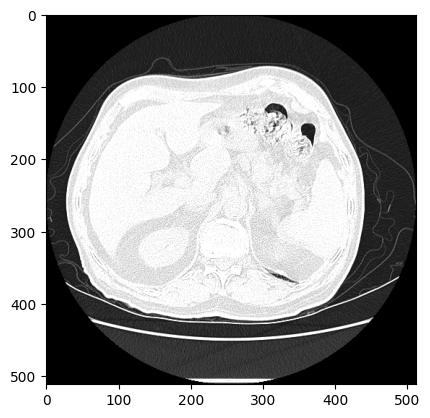

Label: COVID-19


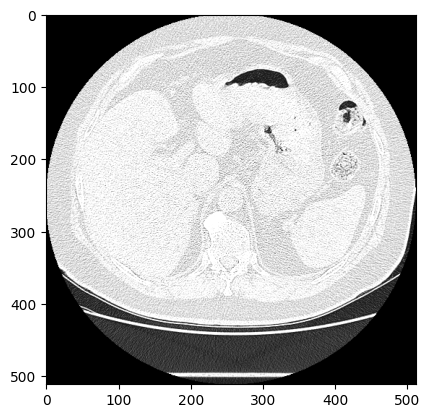

Label: COVID-19


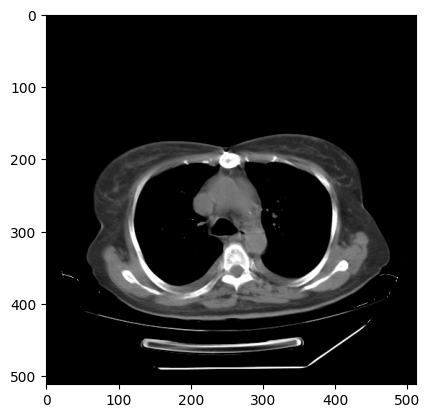

Label: Non-COVID-19


In [10]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape)
for i in range(4):
    img = images[i].squeeze()
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {classes[labels[i]]}")

## Train Model

In [67]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16, 6, 6)
        self.conv4 = nn.Conv2d(6, 1, 5)
        self.pool2 = nn.MaxPool2d(4, 4)
        self.fc1 = nn.Linear(14 * 14, 84)
        self.fc2 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool2(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        embedding = x.clone()
        x = self.fc2(x)
        return x, embedding

net = Net()

In [68]:
## Skewed Model

# 944 have label 0
# 7495 have label 1

weight_0 = (944 + 7495) / 944
weight_1 = (944 + 7495) / 7495
class_weights = [weight_0/weight_0, weight_1/weight_0]
weight_tensor = torch.tensor(class_weights)
weight_tensor

tensor([1.0000, 0.1260])

In [70]:
criterion = nn.CrossEntropyLoss(weight=weight_tensor)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
num_epochs = 5
train_loss = []

In [71]:
start = time.time()
for epoch in range(num_epochs):
    epoch_start = time.time()
    running_loss = 0.0
    epoch_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.float()
        optimizer.zero_grad()

        outputs, embeddings = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    train_loss.append(epoch_loss / 6751)
    print(f'{epoch + 1} loss: {epoch_loss / 6751:.3f} time to train: {time.time() - epoch_start}')

print('Finished Training')
print('total time to train', time.time() - start)

1 loss: 0.150 time to train: 412.9482789039612
2 loss: 0.149 time to train: 403.01173305511475
3 loss: 0.150 time to train: 408.40091705322266
4 loss: 0.150 time to train: 389.03834080696106
5 loss: 0.151 time to train: 384.0610890388489
Finished Training
total time to train 1997.5168159008026


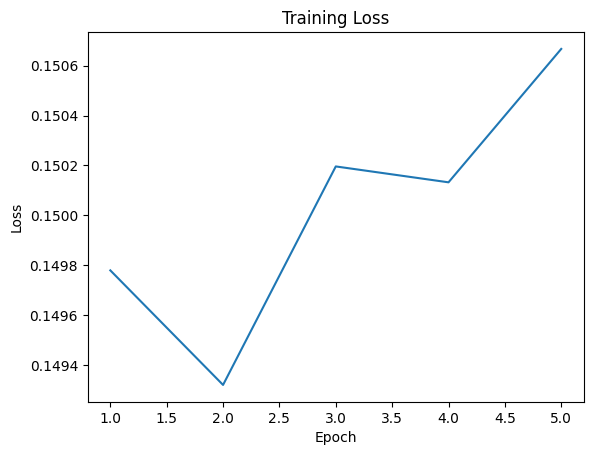

In [72]:
epochs = range(1, num_epochs + 1)

plt.plot(epochs, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [54]:
### Save Model
torch.save(net.state_dict(), './covid_net.pth')

## Test Model

torch.Size([4, 1, 512, 512])


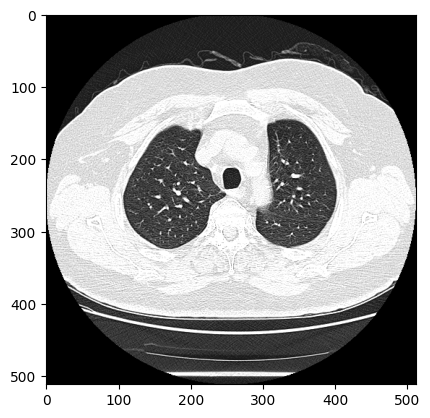

Label: COVID-19


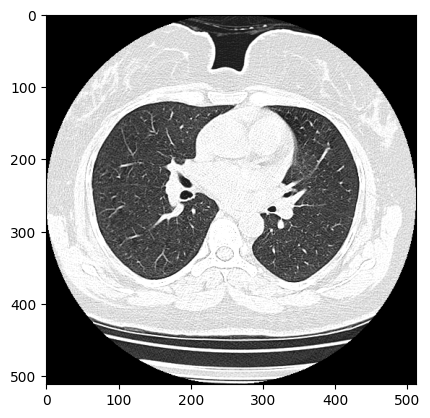

Label: COVID-19


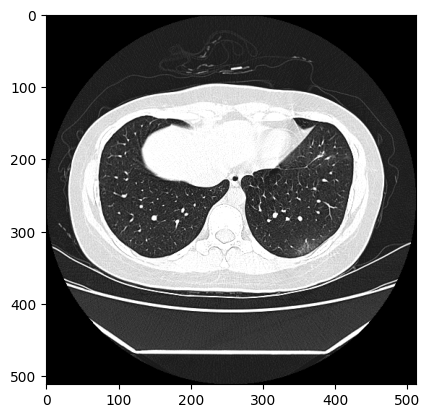

Label: COVID-19


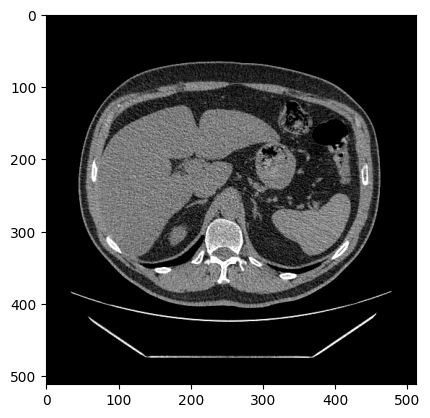

Label: COVID-19


In [55]:
dataiter = iter(testloader)
images, labels = next(dataiter)
print(images.shape)
for i in range(4):
    img = images[i].squeeze()
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {classes[labels[i]]}")

In [56]:
net = Net()
net.load_state_dict(torch.load('./covid_net.pth'))

<All keys matched successfully>

In [57]:
outputs, embeddings = net(images.float())
_, pred = torch.max(outputs, 1)
print('Predicted:', ' '.join(f'{classes[pred[j]]}' for j in range(4)))

Predicted: COVID-19 COVID-19 COVID-19 COVID-19


In [76]:
correct = total = 0
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
covid = noncovid = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs, _ = net(images.float())
        _, pred = torch.max(outputs.data, 1)
        # total += labels.size(0)
        # correct += (pred == labels).sum().item()
        for label, pred in zip(labels, pred):
            # print(label, pred)
            if label == pred:
                correct_pred[classes[label]] += 1
                correct += 1
            total_pred[classes[label]] += 1
            total += 1
            if pred == 0: noncovid += 1
            else: covid += 1

In [78]:
outputs, _ = net(images.float())
_, pred = torch.max(outputs.data, 1)
print(outputs, outputs.data, pred)

tensor([[-0.4640,  0.4630],
        [-0.4640,  0.4630],
        [-0.4640,  0.4630]], grad_fn=<AddmmBackward0>) tensor([[-0.4640,  0.4630],
        [-0.4640,  0.4630],
        [-0.4640,  0.4630]]) tensor([1, 1, 1])


In [77]:
print(f'Accuracy of net: {100 * correct // total} %')
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname} is {accuracy:.3f} %')
print(f'# of NonCovid Pred: {noncovid} # of Covid Pred: {covid}')

Accuracy of net: 89 %
Accuracy for class: Non-COVID-19 is 0.000 %
Accuracy for class: COVID-19 is 100.000 %
# of NonCovid Pred: 0 # of Covid Pred: 1687


In [61]:
total_pred

{'Non-COVID-19': 182, 'COVID-19': 1505}

## Save Embeddings

In [ ]:
embeddings = []
